# Analysis of the DSAIR model

> A number of replications and extensions of The Anh et al.'s analysis of their DSAIR model.

In [ ]:
#| default_exp analysis_dsair

In [ ]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.methods import *
from gh_pages_example.payoffs import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import typing

import fastcore.test
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import seaborn as sns 

This notebook contains a number of analyses of different versions of the DSAIR model.

Each analysis involves a number of steps:

1. Create parameter space
2. Run the model
3. Process the results
4. Visualise the results
5. Explain the patterns observed

## Analysis of the baseline DSAIR model

### Create parameter space

In [ ]:
#| export
def fig1_data(b=4, c=1, B=10**4, W=100, β=0.01, Z=100, S=['A','B'], gamma=1):
    """Create parameter grid for the baseline DSAIR model, Figure 1,
    The Anh et al. 2020."""
    namesofvalues=['s','b','c','p','B','W','β','gamma']
    matchingvalues = np.array([[s,b,c,p,B,W,β,gamma]
                               for s in np.arange(1,5.1,0.1)
                               for p in np.arange(0,1.02,0.02)])
    models = {k:v for k, v in zip(namesofvalues, matchingvalues.T)}
    models = {**models,
              'Z':Z, # Z should be a scalar
              'strategy_set':S # S should be a list of strings
             }
    return models

In [ ]:
#| export
b=4; c=1; B=10**4; W=100; β=0.1; Z=100; S=["AS", "AU"]; gamma=1
models = fig1_data(b=b, c=c, B=B, W=W, β=β, Z=Z, S=S, gamma=1)

### Run the model

In [ ]:
#| export
results = thread_macro(models,
                       payoffs_sr,
                       payoffs_lr,
                       threshold_society_prefers_safety_dsair,
                       threshold_risk_dominant_safety_dsair,
                       markov_chain,
                      )

/home/paololaptop/mambaforge/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
#| hide
{k:v.shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'b': (2091,),
 'c': (2091,),
 'p': (2091,),
 'B': (2091,),
 'W': (2091,),
 'β': (2091,),
 'gamma': (2091,),
 'payoffs_sr': (2091, 2, 2),
 'payoffs': (2091, 2, 2),
 'threshold_society_prefers_safety': (2091,),
 'threshold_risk_dominant_safety': (2091,),
 'transition_matrix': (2091, 2, 2),
 'ergodic': (2091, 2)}

### Process the results

Now that we have collected some results, we need to process them so that we can display what we want to.

The general approach I follow is to flatten the `results` dictionary and convert it into a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) dataframe.

Here, we also compute the risk of an AI related disaster, $p_{risk} = 1 - p$

In [ ]:
#| hide
#| export

flat_results = {k:results[k] for k in ['s','b','c','p','B','W','β']}
flat_results['pr'] = np.round(1 - flat_results['p'], 2)
flat_results['s'] = np.round(flat_results['s'], 2)
for i, strategy in enumerate(["AS", "AU"]):
    flat_results[strategy + "_frequency"] = results['ergodic'][:,i]
    
df = pandas.DataFrame(flat_results)

In [ ]:
#| export
#| hide-input
df

,s,b,c,p,B,W,β,pr,AS_frequency,AU_frequency
0,1.0,4.0,1.0,0.00,10000.0,100.0,0.1,1.00,1.0,0.0
1,1.0,4.0,1.0,0.02,10000.0,100.0,0.1,0.98,1.0,0.0
2,1.0,4.0,1.0,0.04,10000.0,100.0,0.1,0.96,1.0,0.0
3,1.0,4.0,1.0,0.06,10000.0,100.0,0.1,0.94,1.0,0.0
4,1.0,4.0,1.0,0.08,10000.0,100.0,0.1,0.92,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2086,5.0,4.0,1.0,0.92,10000.0,100.0,0.1,0.08,0.0,1.0
2087,5.0,4.0,1.0,0.94,10000.0,100.0,0.1,0.06,0.0,1.0
2088,5.0,4.0,1.0,0.96,10000.0,100.0,0.1,0.04,0.0,1.0
2089,5.0,4.0,1.0,0.98,10000.0,100.0,0.1,0.02,0.0,1.0


### Visualise the results

I am using the [Matplotlib](https://matplotlib.org/stable/index.html) library to visualize our data.

#| hide

:::{.callout-note}
Note that there are five types of callouts, including: 
`note`, `tip`, `warning`, `caution`, and `important`.
:::

In [ ]:
#| hide
sns.set_theme(style='darkgrid',palette='deep' ,font='sans-serif', font_scale=1.4)
plt.rcParams["axes.grid"] = False

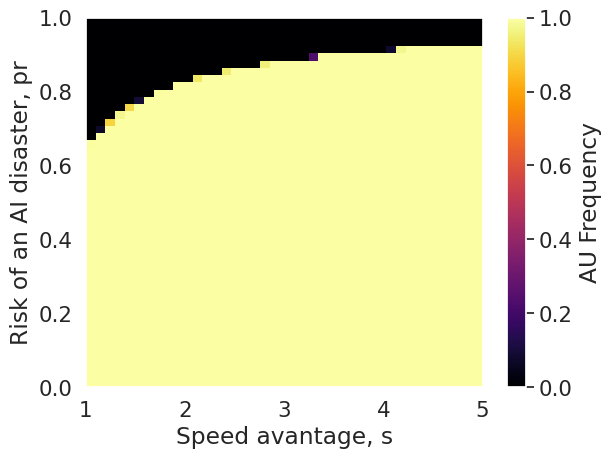

In [ ]:
#| echo:false
table = df.pivot_table(index='pr', columns='s', values='AU_frequency')

heatmap, ax = plt.subplots()
im = ax.imshow(table.values,
               cmap='inferno',
               extent=[table.columns.min(),
                       table.columns.max(),
                       table.index.min(),
                       table.index.max()],
               interpolation='nearest',
               origin='lower',
               aspect='auto')
ax.set(xlabel='Speed avantage, s',
       ylabel='Risk of an AI disaster, pr')

cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('AU Frequency');

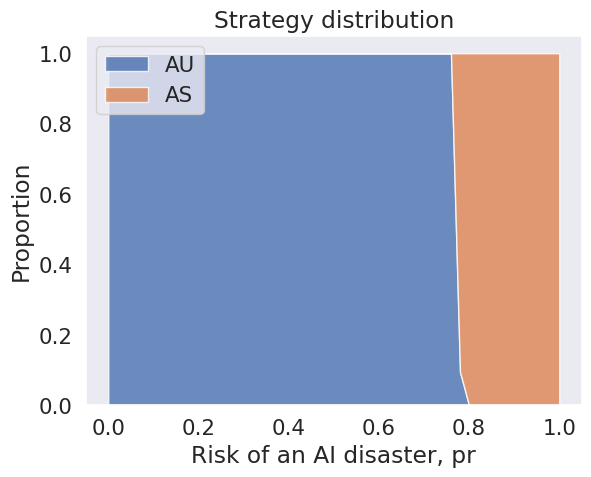

In [ ]:
#| echo:false
dfplot2 = df[df.s==1.5]
x = dfplot2.pr.values
y1 = dfplot2.AU_frequency.values
y2 = dfplot2.AS_frequency.values

fig, ax = plt.subplots()
ax.stackplot(x,
             [y1, y2],
             labels=['AU', 'AS'],
             alpha=0.8)
ax.legend(loc='upper left')
ax.set_title('Strategy distribution')
ax.set_xlabel('Risk of an AI disaster, pr')
ax.set_ylabel('Proportion');

#| hide

### Explain the patterns observed

#| hide

# References

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()